In [213]:
%pylab inline

import pandas as pd
import numpy as np

from calendar import monthrange
from datetime import datetime, date, timedelta

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [269]:
# import given data
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)[['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]

weather = pd.read_csv('../input/weather.csv', index_col=1, parse_dates=['Date'], date_parser=date_parser)[['Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]

In [270]:
# pull some training data
X_train = pd.DataFrame(index=train.index)
X_train['Week'] = train.Date.apply(lambda d: d.isocalendar()[1])
X_train['Year'] = train.Date.apply(lambda d: d.year)
X_train['Species'] = train.Species
X_train['NumMosquitos'] = train.NumMosquitos
X_train['WnvPresent'] = train.WnvPresent

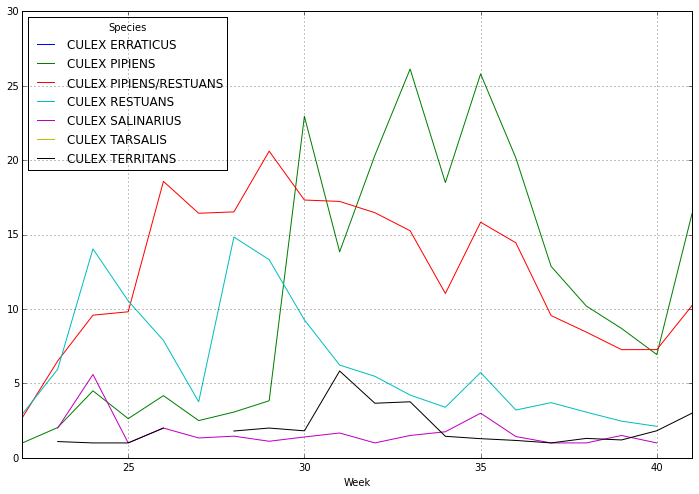

In [271]:
# num mosquitos by week
g_num = X_train.groupby(['Species',  'Week'])['NumMosquitos'].agg(np.mean)
g_num.unstack(level=[0]).plot(kind='line', figsize=(12, 8))

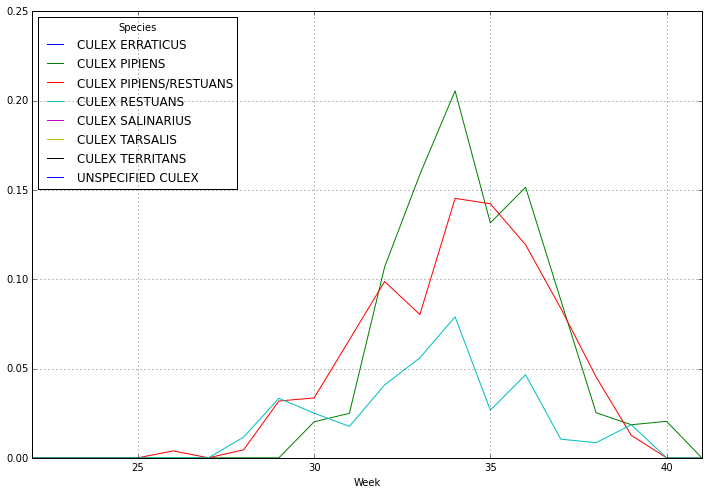

In [339]:
# wnv by week
g_wnv = X_train.groupby(['Species', 'Week'])['WnvPresent'].agg(np.mean)
df_wnv = g_wnv.unstack(level=[0])
df_wnv.fillna(0.0, inplace='True')
df_wnv['UNSPECIFIED CULEX'] = 0.0
df_wnv.plot(kind='line', figsize=(12, 8))

In [343]:
# pull some training data
X_test = pd.DataFrame(index=test.index)
X_test['Week'] = test.Date.apply(lambda d: d.isocalendar()[1])
X_test['Species'] = test.Species

In [348]:
proba = [df_wnv.loc[row['Week'], row['Species']] for index, row in X_test.iterrows()]

In [352]:
import datetime, time
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba, "../working/exploring_dw_" + st + ".csv")